In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

import preprocess # helper preprocessing class

# pyomo
import importlib
import nn_jax_diffrax

To do: Interpolation can be done a single time before training & function saved


In [26]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

importlib.reload(preprocess)
DataPreprocessor = preprocess.DataPreprocessor

# , 'temperature': 'var1'
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

layer_widths = [7, 65, 65, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

To do: Interpolation can be done a single time before training & function saved


In [27]:
from datetime import datetime, timedelta

# prepare data ranges
START_DATE = '2015-01-10'
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
date_sequences = [start_date + timedelta(days=i*5) for i in range(10)]
date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
print(date_sequences_str)

times_elapsed = []

['2015-01-10', '2015-01-15', '2015-01-20', '2015-01-25', '2015-01-30', '2015-02-04', '2015-02-09', '2015-02-14', '2015-02-19', '2015-02-24']


In [21]:
experiment_results = {}

for START_DATE in date_sequences_str:
    data_loader = DataPreprocessor(file_path, start_date = START_DATE, number_of_points = 400, n_days = 1, m = 1, 
                                   feature_encoding = encoding, split = 200, equally_spaced = True, 
                                   smooth = False, num_nodes_mult = 1)
    
    data_subsample = data_loader.load_data()
    df_train, df_test = data_loader.preprocess_data(data_subsample)

    node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
    state = node_model.create_train_state(rng, learning_rate)

    ys = jnp.atleast_2d(jnp.array(df_train['y'])).T
    ts = jnp.array(df_train['t'])
    Xs = jnp.array(df_train.drop(columns=['y', 't']))
    extra_args = (Xs, ts)
    y0 = jnp.array(ys[0])

    start_time = time.time()
    state = node_model.train(state, ts[:] 
                            , ys[:], y0
                            , num_epochs = 1000
                            , extra_args = extra_args[:]
                            )
    end_time = time.time()
    
    y_train_pred = node_model.neural_ode(state.params, y0, ts, state, extra_args)
    
    experiment_results[START_DATE] = {}
    experiment_results[START_DATE]['times_elapsed'] = end_time - start_time
    
    experiment_results[START_DATE]['mae_diffrax'] = np.mean(np.abs(np.squeeze(y_train_pred) - np.squeeze(ys)))
    experiment_results[START_DATE]['mse_diffrax'] = np.mean(np.square(np.squeeze(y_train_pred) - np.squeeze(ys)))
    # -------------------------------------------- DIFFRAX NODE PREDICTION (TRAIN) --------------------
    plt.figure(figsize=(15, 7))
    plt.plot(ts, ys, 'r--', label='True Data')  
    plt.plot(ts, np.squeeze(y_train_pred), 'b' ,label='Predicted Data') 
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.title(f"Diffrax Neural ODE - Train Data")
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.savefig(f'plots/diffrax/diffrax_solver_train_{START_DATE}.png', format='png')  
    plt.close() 

    # -------------------------------------------- DIFFRAX NODE PREDICTION (TEST) --------------------
    ys_test = jnp.atleast_2d(jnp.array(df_test['y'])).T
    ts_test = jnp.array(df_test['t'])
    Xs_test = jnp.array(df_test.drop(columns=['y', 't']))
    extra_args_test = (Xs_test, ts_test)
    y0_test = jnp.array(ys_test[0])
    
    y_test_pred = node_model.neural_ode(state.params, y0_test, ts_test, state, extra_args_test)
    
    experiment_results[START_DATE]['mae_diffrax_test'] = np.mean(np.abs(np.squeeze(y_test_pred) - np.squeeze(ys_test)))
    experiment_results[START_DATE]['mse_diffrax_test'] = np.mean(np.square(np.squeeze(y_test_pred) - np.squeeze(ys_test)))

To do: Interpolation can be done a single time before training & function saved
Epoch 100, Loss: 1.0233817100524902
Epoch 200, Loss: 0.9205619692802429
Epoch 300, Loss: 0.7978276014328003
Epoch 400, Loss: 0.724234938621521
Epoch 500, Loss: 0.6922333836555481
Epoch 600, Loss: 0.6585514545440674
Epoch 700, Loss: 0.5930498242378235
Epoch 800, Loss: 0.5366203188896179
Epoch 900, Loss: 0.5139034986495972
Epoch 1000, Loss: 0.4755847752094269


In [23]:
ys_test = jnp.atleast_2d(jnp.array(df_test['y'])).T
ts_test = jnp.array(df_test['t'])
Xs_test = jnp.array(df_test.drop(columns=['y', 't']))
extra_args_test = (Xs_test, ts_test)
y0_test = jnp.array(ys_test[0])


In [24]:
y_test_pred = node_model.neural_ode(state.params, y0_test, ts_test, state, extra_args_test)

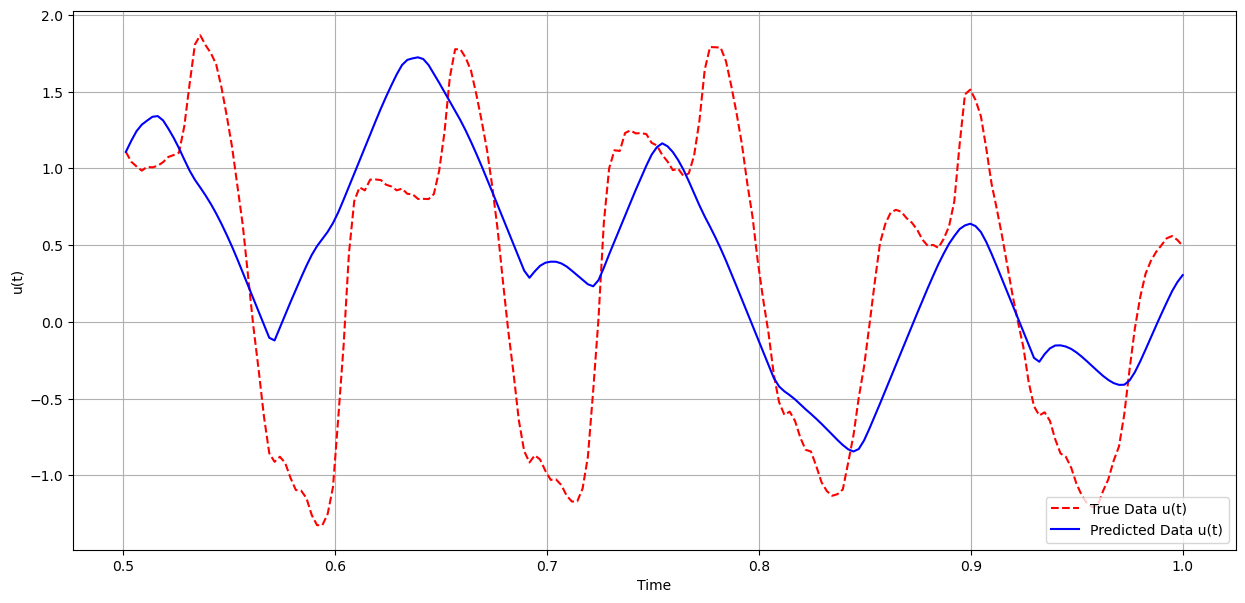

In [25]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts_test, ys_test, 'r--', label='True Data u(t)')  
plt.plot(ts_test, np.squeeze(y_test_pred), 'b', label='Predicted Data u(t)') 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()